# Image Classification

## Preparation


### Prequisite Installation

In [31]:
!pip install -U --upgrade-strategy only-if-needed -r requirements.txt

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached anyio-4.8.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached asttokens-3.0.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached async_lru-2.0.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached cleo-2.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached crashtest-0.4.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached debugpy-1.8.12-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached decorator-5.2.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached distlib-0.3.9-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cac

### Import requirement

In [32]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import io
import seaborn as sns
from PIL import Image

# System libraries
from pathlib import Path
import os.path

# Metrics
sns.set_style('darkgrid')

# Kaggle Dataset
import kagglehub

In [ ]:
tf.version.VERSION

'2.18.0'

### Data Scraping and Preparation

- Data will be pulled from Google Scrapped Image Set. <ref> https://www.kaggle.com/datasets/duttadebadri/image-classification/code </ref>
- Data classes are 4 and will be cleaned before use as seen below. folder name has lot of typo
- for simplification the classname used will be first word of the classes
- Data for training and validation will be splitted from main images sub directory where it has around 32k image
- Validation sub directory will be used for testing with 122 images count

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%run /content/drive/MyDrive/Colab\ Notebooks/scraping.ipynb

Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10246  100 10246    0     0  22615      0 --:--:-- --:--:-- --:--:-- 22618


100%|██████████| 5.39G/5.39G [04:24<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1
There are 1 directories and 0 images in '/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1'.
There are 2 directories and 0 images in '/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes'.
There are 9 directories and 0 images in '/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test'.
There are 0 directories and 223 images in '/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test/organic waste'.
There are 0 directories and 105 images in '/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test/light bulbs'.
There are 0 directories and 256 images in '/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test/glass waste'.
Ther

In [ ]:
path = r"/content/dataset/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes"

train_dir = path + r"/train"
test_dir = path + r"/test"

Found 9214 files belonging to 9 classes.
Using 7372 files for training.
Train Classes: ['E-waste', 'automobile wastes', 'battery waste', 'glass waste', 'light bulbs', 'metal waste', 'organic waste', 'paper waste', 'plastic waste']
Training Dataset Size: 7372
Found 9214 files belonging to 9 classes.
Using 1842 files for validation.
Validation Classes: ['E-waste', 'automobile wastes', 'battery waste', 'glass waste', 'light bulbs', 'metal waste', 'organic waste', 'paper waste', 'plastic waste']
Validation Dataset Size: 1842
Found 2308 files belonging to 9 classes.
Test Classes: ['E-waste', 'automobile wastes', 'battery waste', 'glass waste', 'light bulbs', 'metal waste', 'organic waste', 'paper waste', 'plastic waste']
Test Dataset Size: 2308


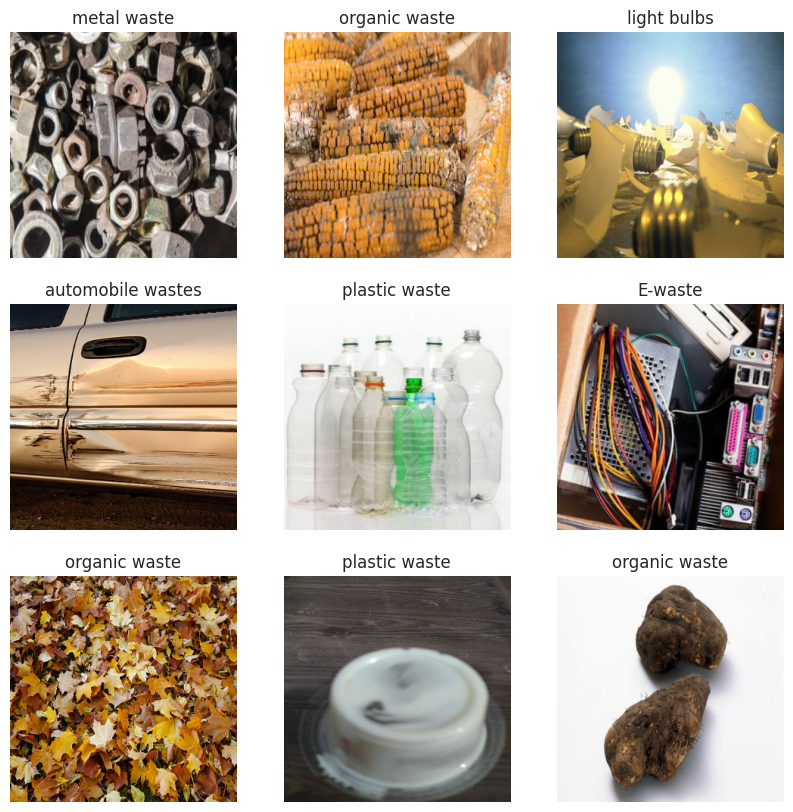

In [ ]:
IMAGE_SIZE = (300, 300)  # Fix image size format
BATCH_SIZE = 32

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)
train_class_names = train_dataset.class_names
print(f"Train Classes: {train_class_names}")
print(f"Training Dataset Size: {len(train_dataset.file_paths)}")
print("==============================================================")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

val_class_names = val_dataset.class_names
print(f"Validation Classes: {val_class_names}")

print(f"Validation Dataset Size: {len(val_dataset.file_paths)}")
print("==============================================================")

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

test_class_names = test_dataset.class_names
print(f"Test Classes: {test_class_names}")
print(f"Test Dataset Size: {len(test_dataset.file_paths)}")
print("==============================================================")

class_length = len(train_class_names)

sample_data = train_dataset.take(1)

# Display sample images
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

### Image Dataset Preparation
>- Data Augmentation using 2 type: Flip and Rotate, Brightness and Contrast
>- Augmentation to dataset will have 4 types of data: original, flip-rotate, brightnaess-contrast, and flip-rotate+brightness-contrast
>
>- Label Encoding for categorical prediction

In [ ]:
# Data Augmentation Layer
flip_rotate = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
])

brightness_contrast = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


In [ ]:
# Label Encoding
def encode_dataset(dataset):
  return dataset.map(lambda x, y: (
      x,
      tf.one_hot(y, depth=class_length)
  ))

# Data Augmentation Implementation
def augmenting_dataset(dataset):
   flop_rotate_ds = dataset.map(lambda x, y: (
      flip_rotate(x, training=True),
      y
  ))
   brightness_contrast_ds = dataset.map(lambda x, y: (
      brightness_contrast(x, training=True),
      y
  ))
   combined_ds = dataset.map(lambda x, y: (
      brightness_contrast(flip_rotate(x, training=True), training=True),
      y
  ))
   return dataset.concatenate(
       combined_ds.concatenate(
        flop_rotate_ds.concatenate(brightness_contrast_ds)
       )
    )

In [ ]:
# Augment then encode label
train_data = encode_dataset(augmenting_dataset(train_dataset))
val_data = encode_dataset(augmenting_dataset(val_dataset))

for images, labels in train_data.take(1):
    print("Image batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Sample label:", labels[0].numpy())


Image batch shape: (32, 300, 300, 3)
Labels batch shape: (32, 9)
Sample label: [0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
# Prefetching data

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


## Training

### Training Preparation

- Creating custom callback where training will be stopped if accuracy and validation accuracy is above 95%
- Creating Callback Builder to create required callbacks
- Creating Plot History to plot history into graph

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        acc = logs.get('accuracy')
        val_acc = logs.get("val_accuracy")

        if acc > 0.95 and val_acc > 0.95:
            print(f"Stopping training at accuracy: {acc} val_accuracy: {val_acc}")
            self.model.stop_training = True

In [ ]:
def build_callbacks(
    factor=0.1,
    patience=4,
    filepath=None,
    custom_callback=CustomCallback(),
):
    callbacks = []
    callbacks.append(custom_callback)

    def lr_scheduler(epoch, lr):
        if epoch < 5:
            return lr
        elif epoch < 10:
            return lr * 0.5
        else:
            return lr * 0.1

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    callbacks.append(lr_callback)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True
    )
    callbacks.append(early_stopping)

    if not filepath:
        return callbacks

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='val_accuracy',
        verbose=2,
        save_best_only=True,
    )

    callbacks.append(checkpoint_callback)

    return callbacks

In [ ]:
def plot_history(history, model_name="Model"):
  model_acc = history.history['accuracy']
  model_val_acc = history.history['val_accuracy']

  model_loss = history.history['loss']
  model_val_loss = history.history['val_loss']

  epoch_range = range(len(model_acc))

  plt.figure(figsize = (12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_range, model_acc, label='Training Accuracy')
  plt.plot(epoch_range, model_val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_range, model_loss, label='Training Loss')
  plt.plot(epoch_range, model_val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Loss {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')

  plt.show()

In [ ]:
def train_model(model, train_data, val_data, epochs=10, steps=None, callbacks=None):
    print(f"start training with callbacks: {callbacks}")
    return model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        steps_per_epoch=steps
    )

### Model building
- Base for transfer model used is MobileNetV3Large
>
- Model is using Sequential API and divided into 6 parts:
> - 1. Input Layer - Data input
> - 2. Augmentation Layer - Data Augmentation. e.g: rescale, flip and rotation
> - 3. Pretrained Layer - Pretrained Model layer
> - 4. Requirement Layer - Dicoding CNN required layer
> - 5. Additional Layer - Dense Layer for connecting CNN into output
> - 6. Output Layer - Converting Predicted output into Class Length
>
- Consideration for picking this model is:
> - 1. model is pretty small and simple
> - 2. premade model preprocessing can be opted out
> - 3. required layer is actually improving the model performance and not hindering it (atop of simple model added pretty complex layer can save the model performance)
> - 4. training is faster and inference even more with pretty limited resource

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB0, ResNet50V2, VGG19
# Initialize ResNet model and freeze it
INPUT_SHAPE = (300, 300, 3)
MODEL_NAME="MobNetTransfer"

BaseModel = MobileNetV3Large(
    weights="imagenet",
    include_top=False,
    input_shape=INPUT_SHAPE,
    include_preprocessing=False # use this on mobilenet,
)

for layer in BaseModel.layers[:-30]:
    layer.trainable = False
for layer in BaseModel.layers[-30:]:
    layer.trainable = True

# Create the sequential model with input shape
transfer_model = tf.keras.Sequential([
    # == Input Layer == #
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    # == Input Layer == #

    # == Augmentation Layer == #
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    # tf.keras.layers.Rescaling(1./255),
    # == Augmentation Layer == #

    # == Pretrained Layer == #
    BaseModel,
    # == Pretrained Layer == #

    # == Requirement Layer == #
    tf.keras.layers.Conv2D(512, (3, 3), kernel_regularizer=tf.keras.regularizers.L2(0.3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.3),
    tf.keras.layers.Conv2D(256, (3, 3), kernel_regularizer=tf.keras.regularizers.L2(0.1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.3),
    tf.keras.layers.GlobalAveragePooling2D(),
    # == Requirement Layer == #

    # == Additional Layer == #
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(5e-3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # == Additional Layer == #

    # == Output Layer == #
    tf.keras.layers.Dense(class_length, activation='softmax')
    # == Output Layer == #
], name=MODEL_NAME)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
transfer_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy',
        'f1_score'
    ]
)

transfer_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobNetTransfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 10, 10, 960)         │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 10, 10, 512)         │       4,424,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 10, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 10, 10, 256)         │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,672,649 (33.08 MB)

 Trainable params: 7,268,969 (27.73 MB)

 Non-trainable params: 1,403,680 (5.35 MB)

In [ ]:
BaseModel.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 150, 150, 16)   │            432 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 150, 150, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 150, 150, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 150, 150, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 150, 150, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 150, 150, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 150, 150, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 150, 150, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 150, 150, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 150, 150, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 150, 150, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 150, 150, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 151, 151, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 1,594,720 (6.08 MB)

 Non-trainable params: 1,401,632 (5.35 MB)

### Model Training
 - Max Epochs is 20
 - FILEPATH constant to define saved model filename and path
 - patience parameter for Reduced Learning Rate callback patience

In [ ]:
EPOCHS=20
FILEPATH="mobnet-transfer.keras"

callbacks = build_callbacks(
    filepath=FILEPATH,
    patience=3
)

transfer_history = train_model(
    transfer_model,
    train_data,
    val_data,
    epochs=EPOCHS,
    callbacks=callbacks,
)

start training with callbacks: [<__main__.CustomCallback object at 0x7c2509657b50>, <keras.src.callbacks.learning_rate_scheduler.LearningRateScheduler object at 0x7c250969f5d0>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7c25094acfd0>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7c250976c9d0>]
Epoch 1/20
924/924 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6219 - f1_score: 0.6153 - loss: 90.3919
Epoch 1: val_accuracy improved from -inf to 0.81569, saving model to mobnet-transfer.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 420s 143ms/step - accuracy: 0.6220 - f1_score: 0.6154 - loss: 90.3364 - val_accuracy: 0.8157 - val_f1_score: 0.8213 - val_loss: 4.0733 - learning_rate: 1.0000e-04
Epoch 2/20
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8273 - f1_score: 0.8287 - loss: 3.2031
Epoch 2: val_accuracy improved from 0.81569 to 0.82885, saving model to mobnet-transfer.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.8274 - f1_score: 

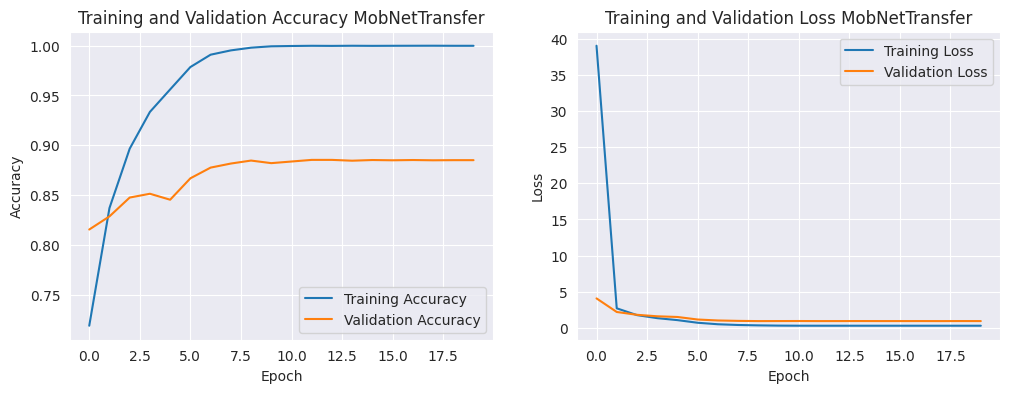

In [ ]:
# Plotting ResNet model
plot_history(transfer_history, transfer_model.name)

## Inference

### Validation Inference

- data is from valdidation sub directory
- model used is from saved best model from training in FILEPATH constant
- real validation is around ~85 - ~88 percent accuracy

In [ ]:
test_df = pd.DataFrame(columns=['image_path', 'label'])

test_data = encode_dataset(test_dataset)
test_data = test_data

In [ ]:
transfered_model = tf.keras.models.load_model(FILEPATH)

test_history = transfered_model.evaluate(test_data)
print(test_history)

73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - accuracy: 0.8949 - f1_score: 0.8915 - loss: 0.9305
[0.8457775712013245, 0.9055459499359131, <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.89983577, 0.9164785 , 0.9287356 , 0.9133857 , 0.9054726 ,
       0.8673947 , 0.95045036, 0.93667156, 0.8567072 ], dtype=float32)>]


### Model Export
- Exporting model to SavedModel
- Exporting model to TFJS
- Exporting model to TFLite

In [ ]:
TF_SAVED_MODEL_NAME = "mobnet_transfer_saved"
transfered_model.export(f"{TF_SAVED_MODEL_NAME}")

Saved artifact at 'mobnet_transfer_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  136498641135248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625576016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625565072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498641134864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625569680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625165072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625151440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625151824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625157392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625162000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13649862

In [ ]:
TFJS_MODEL_NAME = "mobnet_transfer"
tfjs.converters.save_keras_model(transfered_model, f"{TFJS_MODEL_NAME}")

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
TFLITE_MODEL_NAME = 'mobnet-transfer-lite'
converter = tf.lite.TFLiteConverter.from_keras_model(transfered_model)
tflite_model = converter.convert()
open(f"{TFLITE_MODEL_NAME}.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmpzxgu0f4b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  136498641135248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625576016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625565072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498641134864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625569680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625165072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625151440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625151824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625157392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136498625162000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364986251535

34586572

### Testing exported model

In [ ]:
loaded_model = tf.lite.Interpreter(model_path=f"{TFLITE_MODEL_NAME}.tflite")

loaded_model.allocate_tensors()

input_details = loaded_model.get_input_details()
output_details = loaded_model.get_output_details()

def predict_tflite(image_tensor):
    if len(image_tensor.shape) == 3:
        image_tensor = tf.expand_dims(image_tensor, axis=0)

    loaded_model.set_tensor(input_details[0]['index'], image_tensor)
    loaded_model.invoke()
    return loaded_model.get_tensor(output_details[0]['index'])

total = 0
correct = 0

for images, labels in test_data:
  for image, label in zip(images, labels):
    total += 1

    ACTUAL_CLASS = train_class_names[tf.argmax(label).numpy()]
    pred_class = np.argmax(predict_tflite(image))
    act_classname = train_class_names[pred_class]

    if ACTUAL_CLASS == act_classname:
      correct += 1
    else:
      print("-- PREDICTION MISS --")

    print(f"prediction: {act_classname} actual: {ACTUAL_CLASS}")
    print("================================================================")

print("================================================================")
print(f"accuracy: {correct/total}")

prediction: paper waste actual: paper waste
prediction: glass waste actual: glass waste
prediction: metal waste actual: metal waste
prediction: metal waste actual: metal waste
prediction: automobile wastes actual: automobile wastes
prediction: metal waste actual: metal waste
prediction: metal waste actual: metal waste
prediction: E-waste actual: E-waste
prediction: automobile wastes actual: automobile wastes
prediction: automobile wastes actual: automobile wastes
prediction: organic waste actual: organic waste
prediction: metal waste actual: metal waste
-- PREDICTION MISS --
prediction: E-waste actual: automobile wastes
-- PREDICTION MISS --
prediction: glass waste actual: organic waste
prediction: E-waste actual: E-waste
prediction: plastic waste actual: plastic waste
prediction: metal waste actual: metal waste
prediction: plastic waste actual: plastic waste
prediction: E-waste actual: E-waste
-- PREDICTION MISS --
prediction: automobile wastes actual: glass waste
prediction: plastic 